<h1 align="center">
        <picture>
         <source media="(prefers-color-scheme: dark)" srcset="https://user-images.githubusercontent.com/16140783/218357099-29d4848f-89ee-463e-9ead-40f27c976f61.png">
         <img width="300" src="https://user-images.githubusercontent.com/16140783/218437368-1aa8506c-1ed8-460a-99de-d2c081557170.png" align="center"></img>
    </picture><br/><br/>Subvocalization EMG
</h1>

Project for recording and training subvocalization **EMG** data with the Cyton Board. This is the PoC of the project containing the steps of processing and training. Developed by **Mateus de Aquino Batista** for the Bachelor's Degree Final Project.


### Packages

First, after recording the raw data with Brainflow, we can start processing the data, so let's start installing the required packages for reading the saves, preprocessing, plotting and training a new model.

Disclaimer: note that while the researchers are waiting for the ethics and research committee approval we must use the Synthetic board for now.

In [1]:
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations
from brainflow.board_shim import BoardShim, BoardIds
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import np_utils

### Reading raw EMG data

The sEMG data will be read from the Cyton Dongle through [BrainFlow](https://brainflow.readthedocs.io/en/stable/SupportedBoards.html#cyton), you can also check the [Code Samples](https://brainflow.readthedocs.io/en/stable/Examples.html) section to know how to get the data from the board and read/write it to a csv file.

In [2]:
restored_data = pd.read_csv("dist/saves/Unprocessed.csv")

restored_data

,WORD,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,Obrigado,8.268304,27.871987,11.122740,76.184598,10.535622,150.642708,-66.598765,202.367970
1,Obrigado,6.312490,35.943134,-4.050802,99.959342,-18.376594,150.067860,-41.917993,147.220440
2,Obrigado,4.548397,41.236865,-9.974052,92.963126,-26.810435,112.864029,53.465690,61.439370
3,Obrigado,2.895331,45.597516,-11.275577,92.342478,19.853145,48.895321,121.129111,-46.998268
4,Obrigado,1.439590,47.789123,-7.367979,66.973665,61.559856,-2.168209,184.420149,24.689898
...,...,...,...,...,...,...,...,...,...
747,Bebida,13.449913,7.533644,55.269869,-5.170679,117.052825,-20.087365,145.150873,-58.919902
748,Bebida,11.838088,14.109925,43.319893,18.039139,81.445920,23.611317,142.270647,-14.717527
749,Bebida,10.000000,21.419386,25.282292,48.342464,39.254047,81.210223,34.824948,104.351573
750,Bebida,8.229302,27.621490,9.347753,73.209856,-10.762248,144.315923,-3.055201,387.647618


The Cyton board has 8 channels.  

We can check this out and plot the data for each channel directly to [Matplotlib](https://matplotlib.org/). As you could tell, these graphing tools have a way higher resolution than the one used in the frontend for debugging ([Chart.js](https://www.chartjs.org/)).

[1, 2, 3, 4, 5, 6, 7, 8]
['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

Plot channels:


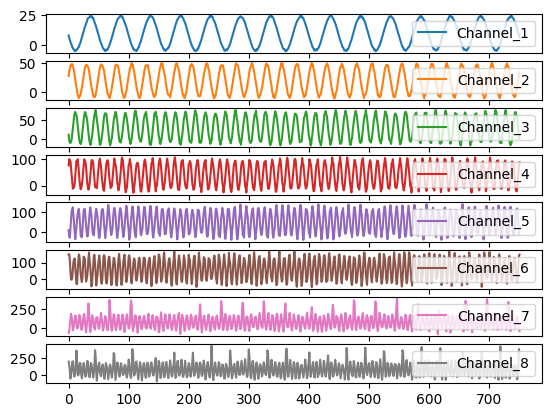

In [4]:
board_id = BoardIds.CYTON_BOARD.value
eeg_channels = BoardShim.get_eeg_channels(board_id)
df_channels = list(map(lambda x: "Channel_%s" % (x), eeg_channels))
print(eeg_channels)
print(df_channels)
print("\nPlot channels:")

axs = restored_data[df_channels].plot(subplots=True)
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")

plt.show()

### Preprocessing

With our 8 channels data in hand, we can perform a Butterworth filter to select the frequency range we want to keep, here we want a lowcut of 3.0 and a highcut of 45.0:

In [5]:
sampling_rate = BoardShim.get_sampling_rate(board_id)
exg_channels = BoardShim.get_exg_channels(board_id)

curves = [None] * 8
for count, channel in enumerate(df_channels):
    if count >= 8:
        continue
    channel_data = restored_data[channel].to_numpy()
    DataFilter.detrend(channel_data, DetrendOperations.CONSTANT.value)
    DataFilter.perform_bandpass(channel_data, sampling_rate, 3.0, 45.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandstop(channel_data, sampling_rate, 48.0, 52.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandstop(channel_data, sampling_rate, 58.0, 62.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    curves[count] = channel_data.tolist()
    

preprocessed_data = pd.DataFrame(np.transpose(curves))

preprocessed_data

,0,1,2,3,4,5,6,7
0,-0.233258,1.067043,-2.544951,4.857994,-5.361643,12.275748,-19.776149,14.970490
1,-1.067688,4.764869,-10.809183,19.926504,-22.356411,42.091288,-64.573173,43.914933
2,-2.429393,10.325386,-21.806163,36.703938,-43.960260,61.709024,-83.469428,44.275102
3,-3.951071,15.687711,-30.007804,44.433426,-52.324765,49.523893,-50.344762,-3.161532
4,-5.334939,19.493841,-32.564969,40.273538,-35.342409,8.626240,13.382069,-61.490137
...,...,...,...,...,...,...,...,...
747,-6.846623,-9.474639,32.912196,-59.698335,61.065651,-45.915408,28.550600,11.578956
748,-8.331395,-2.779635,20.802492,-44.957577,62.159586,-68.745444,68.994415,-58.721072
749,-9.644282,4.501026,5.569799,-18.701445,40.586381,-52.110569,47.473015,-88.123930
750,-10.822950,11.184814,-9.854522,9.739082,-0.815820,-0.747501,-8.808160,-13.149353


We can also plot these curves to see the difference between the unprocessed data, note the scales also were reduced since we removed unused information:

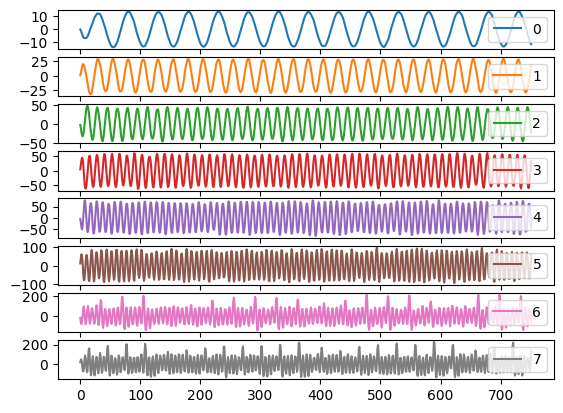

In [7]:
axs = preprocessed_data.plot(subplots=True)
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")

plt.show()

In this session we recorded 6 words with the Synthetic board.
Now that we have all the session preprocessed, we need to split it in six parts. However, some words might be recorded with an average of ± 2 extra samples, therefore, we also need to map all the splits to have the same size:

In [8]:
emg_words = []
emg_data = []
curves = pd.DataFrame(curves)

word = None
data = None
for i in range(len(restored_data)):
    if i == 0:
        word = restored_data.iloc[i, 0]
        data = curves[i]
    elif restored_data.iloc[i, 0] == word:
        data = np.vstack((data, curves[i]))
    else:
        emg_words.append(word)
        emg_data.append(data)
        word = restored_data.iloc[i, 0]
        data = curves[i]

emg_words.append(word)
emg_data.append(data)
# We need all samples to have the same size, so we standardize it to have the lowest size
samples = min([len(x) for x in emg_data])
data_reduced = [x[:samples] for x in emg_data]
emg_data = np.asarray(data_reduced).astype('float32')

print("Recorded words in order: " + ', '.join(emg_words))
print("\nEMG data for the first word ('%s'):" % (emg_words[0]))

pd.DataFrame(emg_data[0])

Recorded words in order: Obrigado, Comida, Obrigado, Ligar, Tchau, Bebida

EMG data for the first word ('Obrigado'):


,0,1,2,3,4,5,6,7
0,-0.233258,1.067043,-2.544950,4.857994,-5.361643,12.275747,-19.776150,14.970490
1,-1.067688,4.764869,-10.809183,19.926504,-22.356411,42.091290,-64.573174,43.914932
2,-2.429393,10.325386,-21.806164,36.703938,-43.960258,61.709023,-83.469429,44.275101
3,-3.951071,15.687712,-30.007803,44.433426,-52.324764,49.523891,-50.344761,-3.161532
4,-5.334939,19.493841,-32.564968,40.273537,-35.342411,8.626240,13.382070,-61.490135
...,...,...,...,...,...,...,...,...
120,4.038626,-23.623911,-38.921143,-37.908421,-4.851695,42.951298,66.725006,45.746124
121,5.537502,-18.406614,-37.443577,-54.636967,-45.697025,-5.762184,14.949058,77.149834
122,7.055022,-10.970231,-31.652142,-57.279495,-65.421600,-54.699291,-53.329891,3.911051
123,8.484909,-2.562384,-21.849644,-42.863590,-59.536785,-75.875923,-84.369286,-102.731476


### Words visualization

These words are now a 2d array (sample x channel) inside a list of words. Which means all the words could be individually seen as a 2-dimensional image heatmap, knowing the columns represents each channel, and the rows are the data recorded over time. As the writing date of this PoC, no human data was yet recorded, and as we are using the Synthetic board we may see some patterns in the image, also they all look pretty similar:

<Figure size 640x480 with 0 Axes>

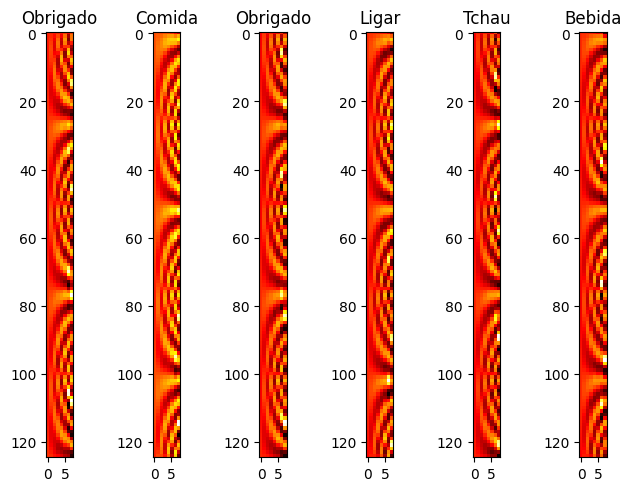

In [10]:
plt.figure()
_f, axarr = plt.subplots(1, len(emg_words), constrained_layout=True)
for i, word in enumerate(emg_words):
    axarr[i].imshow(emg_data[i], cmap='hot', interpolation='none')
    axarr[i].title.set_text(word)
plt.show()

### Training the Neural Network

We need to factorize the words array so we can get an unique list of the words used, and also retreive a list the model can read as an expected output:

In [11]:
words, words_map = pd.factorize(emg_words)
words = to_categorical(words)
possibilities = len(words_map)
index = list(map(lambda x: "Word %s" % (x), range(1, 7)))

print("This is the expected output, containing only %s possibilities (%s):" % (possibilities, ', '.join(words_map)))

pd.DataFrame(words.astype('int'), columns=words_map, index=index)

This is the expected output, containing only 5 possibilities (Obrigado, Comida, Ligar, Tchau, Bebida):


,Obrigado,Comida,Ligar,Tchau,Bebida
Word 1,1,0,0,0,0
Word 2,0,1,0,0,0
Word 3,1,0,0,0,0
Word 4,0,0,1,0,0
Word 5,0,0,0,1,0
Word 6,0,0,0,0,1


Finally, the colormap only has one color, so all we have to do now is to split the words that will be used to train (90%) and the words used to validate (10%) and submit all these "words" into a single dimensional Convolutional Neural Network (CNN) to create our model:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(emg_data, words, test_size=.10)

model = Sequential()
model.add(Conv1D(40, 10, strides=2, padding='same', activation='relu', input_shape=(samples, 8)))
model.add(Dropout(0.2))
model.add(MaxPooling1D(3))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(possibilities, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=100, epochs=5, verbose=1, shuffle=True)

Epoch 1/5
1/1 [==============================] - 1s 822ms/step - loss: 9.5795 - accuracy: 0.2000 - val_loss: 5.9847 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 9.3821 - accuracy: 0.2000 - val_loss: 5.4139 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 0s 44ms/step - loss: 5.9575 - accuracy: 0.2000 - val_loss: 5.8325 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 0s 36ms/step - loss: 5.8271 - accuracy: 0.6000 - val_loss: 6.9478 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 49ms/step - loss: 7.7151 - accuracy: 0.0000e+00 - val_loss: 7.7321 - val_accuracy: 0.0000e+00


Since this model is unfunctional using the Synthetic board (as it generates random data), the epochs amount is low (5) for demonstration. Now that our model is trained, we can predict single words with a stream of samples gathered from EMG recording:

In [15]:
test_data = emg_data[0].astype('float32')
test_data = np.expand_dims(test_data, axis=0)
prediction_table = model.predict(test_data)

pd.DataFrame(prediction_table, columns=words_map)

1/1 [==============================] - 0s 55ms/step


,Obrigado,Comida,Ligar,Tchau,Bebida
0,0.999996,1.293503e-09,6.380489e-22,6.527801e-18,0.000004


In [17]:
predicted_word_index = np.argmax(prediction_table, axis=1)
predicted_word = pd.DataFrame(words_map).iloc[predicted_word_index].values[0][0]

print("Predicted word: %s" % (predicted_word))

Predicted word: Obrigado


When predicting in real time with a classifier stream, to guarantee the predicted word is right, we can also create a history list with the last ~10 predictions or so, and assume the word being subvocalized is the most seen in the history.